# Chapter 20. Differences among Total, Phase-Locked, and Non-Phase-Locked Power and Intertrial Phase Consistency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import fft, ifft

In [2]:
data = scipy.io.loadmat('../data/sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [3]:
chan2plot = 'O1'

# wavelet params
min_freq = 2
max_freq = 30
num_frex = 20

baseline_time = (-400, 100)

# other wavelet params
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
time = np.arange(-1, 1+1/EEGsrate, 1/EEGsrate)
half_of_wavelet_size = len(time)//2

n_wavelet = len(time)
n_data = EEGpnts*EEGtrials
n_convolution = [n_wavelet + n_data -1] * 2 + [n_wavelet+EEGpnts-1]  # ERP only one trial-length

#sensor index
sensoridx = np.argmax([x[0] == chan2plot for x in EEGchanlocslabels])

# compute erp
erp = EEGdata[sensoridx].mean(1)

# fft of data
baseidx = [np.abs(EEGtimes - baseline_time[0]).argmin(),
           np.abs(EEGtimes - baseline_time[1]).argmin()]

# init output time freq data
tf = np.zeros((4, len(frequencies), EEGpnts))

induced_EEG =  EEGdata[sensoridx] - erp[:, np.newaxis]

fft_EEG = [fft(np.reshape(EEGdata[sensoridx],(EEGpnts*EEGtrials), order='F'), n_convolution[0]),  # total
           fft(np.reshape(induced_EEG, (EEGpnts*EEGtrials), order='F'), n_convolution[1]),  # induced
           fft(erp, n_convolution[2])]  # evoked; n.b. doesnt matter that fft longer than time series

for fi in range(len(frequencies)):

    # create wavelet
    wavelet = (np.exp(2*1j*np.pi*frequencies[fi] * time) *
               np.exp(-time**2/(2*(4/(2*np.pi*frequencies[fi]))**2)))/frequencies[fi]

    # run conv for each trial, induced, and evoked
    for i in range(3):

        # take fft o data
        fft_wavelet = fft(wavelet, n_convolution[i])

        # convolution
        convolution_result_fft = ifft(fft_wavelet*fft_EEG[i], n_convolution[i])
        convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
        # reshape and trial averaging only don on all trials

        if i<2:
            convolution_result_fft = np.reshape(convolution_result_fft, (EEGpnts, EEGtrials), order='F')
            # compute power
            tf[i, fi] = np.mean(np.abs(convolution_result_fft)**2, 1)
        else:
            # with only one trial length, just compute
            tf[i,fi] = np.abs(convolution_result_fft)**2

        # db correct power
        tf[i, fi] = 10*np.log10(tf[i, fi] / (tf[i, fi, baseidx[0]:baseidx[1]]).mean())

        # inter-trial phase consistency on total EEG
        if i == 0:
            tf[3, fi] = np.abs(np.mean(np.exp(1j*np.angle(convolution_result_fft)), 1))

analysis_labels = ['total', 'non-phase-locked', 'erp power', 'itpc']

# color lims
clims = [[-3, 3], [-3, 3], [-12, 12], [0, .6]]

# scale erp for plotting
erpt = (erp - erp.min()) / np.max(erp - np.min(erp))
erpt = erpt * (frequencies[-1] - frequencies[0]) + frequencies[0]

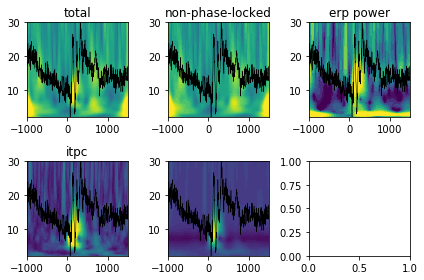

In [4]:
fig, ax = plt.subplots(2,3)

for i in range(4):
    idx = np.unravel_index(i, (2,3))
    ax[idx].contourf(EEGtimes, frequencies, tf[i], 40, vmin=clims[i][0], vmax=clims[i][1])
    ax[idx].set(title=analysis_labels[i])
    ax[idx].plot(EEGtimes, erpt, 'k', linewidth=.5)

ax[1,1].contourf(EEGtimes, frequencies, np.squeeze(tf[0]-tf[1]), 40)

ax[1,1].plot(EEGtimes, erpt, 'k', linewidth=.5)

fig.tight_layout()

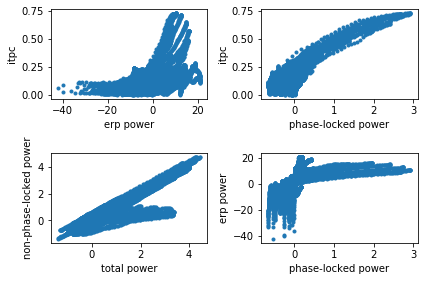

In [5]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(tf[2].flatten(order='f'), tf[3].flatten(order='f'), '.')
ax[0,0].set(xlabel='erp power', ylabel='itpc')

ax[0,1].plot((tf[0] - tf[1]).flatten('f'), tf[3].flatten(order='f'), '.')
ax[0,1].set(xlabel='phase-locked power', ylabel='itpc')

ax[1,0].plot(tf[0].flatten(order='f'), tf[1].flatten(order='f'), '.')
ax[1,0].set(xlabel='total power', ylabel='non-phase-locked power')

ax[1,1].plot((tf[0]-tf[1]).flatten(order='f'), tf[2].flatten(order='f'), '.')
ax[1,1].set(xlabel='phase-locked power', ylabel='erp power')

fig.tight_layout()
